In [63]:
import pandas as pd
import numpy as np
import os, sys
from keras.layers import concatenate
from keras.models import Sequential,Model
from keras.layers import Dense, add, Input, merge, Embedding, Flatten, Dropout, average
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [64]:
df = pd.read_csv("comments.csv")

In [65]:
df.head()

,id,title,comment,rate,verification_status
0,0,کیفیت و حجم صدای عااااالی,این محصول توی بازار اصلاااا پیدا نمیشه من کل ت...,100.0,0
1,1,شش ماه مصرف!!,دوبار از این مدل گرفتم اولاش خوبه ولی بعد از ش...,5.0,0
2,2,کارآیی,به نظر من فقط برای کارای سبک و دیدن فیلم و مطا...,60.0,0
3,3,بررسی کمی و کیفی,برای من بسیار مناسب و خریدش در شگفت انگیز حتما...,0.0,0
4,4,بسته بندی ضعیف,ظاهر بامزه ای داره ولی عکسش شبیه خودش نیست جنس...,60.0,0


In [66]:
df.describe()

,id,rate,verification_status
count,180000.000000,180000.000000,180000.000000
mean,89999.500000,57.757662,0.166667
std,51961.668564,34.254834,0.372679
min,0.000000,0.000000,0.000000
25%,44999.750000,36.000000,0.000000
50%,89999.500000,60.000000,0.000000
75%,134999.250000,86.000000,0.000000
max,179999.000000,100.000000,1.000000


In [67]:
# Filling empty comments or titles with a single space
df = df.fillna(" ")

In [68]:
import hazm
persian_stop_words = hazm.stopwords_list()

In [69]:
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (persian_stop_words)]))
df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (persian_stop_words)]))

In [70]:
df['comment_word_count'] = df['comment'].apply(lambda x: len(x))

In [71]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df['comment_word_count']
))

fig.update_layout(
    title_text='Distribution of word counts within comments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [72]:
df["comment_word_count"].describe()

count    180000.000000
mean         95.815183
std         142.168020
min           0.000000
25%          26.000000
50%          55.000000
75%         113.000000
max        7310.000000
Name: comment_word_count, dtype: float64

In [73]:
data_length = df["comment_word_count"].values
data_glt = sum([1 for length in data_length if 5 < length <= 324])
data_glt_rate = (data_glt / len(data_length)) * 100
print(data_glt_rate, "Percent of sentences have between 5 to 324 words")
minlim, maxlim = 5, 324

92.53611111111111 Percent of sentences have between 5 to 324 words


In [74]:
Y = np.array(df["verification_status"].values)

In [75]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = Y.reshape(len(Y), 1)
y_encoded = onehot_encoder.fit_transform(integer_encoded)

In [76]:
comments = df["comment"].values
titles = df["title"].values

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(comments + titles)

In [77]:
vec_comments = tokenizer.texts_to_sequences(comments)
vec_titles = tokenizer.texts_to_sequences(titles)

In [78]:
vocab_size = len(tokenizer.word_index) + 1 

In [79]:
padd_x_cms = pad_sequences(vec_comments, padding='post', maxlen=maxlim)
padd_x_tt = pad_sequences(vec_titles, padding='post', maxlen=maxlim)

In [80]:
ratings = df["rate"].values
ratings = ratings.reshape(len(ratings), 1)

# Normilize ratings [0,100]
ratings = ratings / 100

In [81]:
data_size = df.count()["id"]
split_point = math.floor(data_size * 0.3)

In [82]:
# Comments
X_train_cm = padd_x_cms[split_point:]
X_test_cm = padd_x_cms[:split_point]

# Titles
X_train_tt = padd_x_tt[split_point:]
X_test_tt = padd_x_tt[:split_point]

# Ratings
X_train_rt = ratings[split_point:]
X_test_rt = ratings[:split_point]

## Y
y_train = y_encoded[split_point:]
y_test = y_encoded[:split_point]

In [83]:
X_train_cm

array([[ 23, 908, 419, ...,   0,   0,   0],
       [968,  50, 626, ...,   0,   0,   0],
       [ 30,  26, 740, ...,   0,   0,   0],
       ...,
       [285, 178, 112, ...,   0,   0,   0],
       [ 23,  68,  31, ...,   0,   0,   0],
       [215, 449,  27, ...,   0,   0,   0]], dtype=int32)

In [84]:
#cmModel0 = Input(shape=X_train_cm.shape[1])
# cmModel1 = Dense(128, activation="relu")(cmModel0)
# cmModel2 = Dense(64, activation="relu")(cmModel1)

cmModel0 = Input(shape=(maxlim,),dtype='float64')  
cmModel1 = Embedding(input_dim=vocab_size,output_dim=8,input_length=maxlim)(cmModel0)
cmModel2 = Flatten()(cmModel1)
cmModel3 = Dropout(0.25)(cmModel2)
cmModel4 = Dense(46, activation="relu")(cmModel3)

# ttModel0 = Embedding(input_dim=vocab_size,output_dim=8,input_length=max_tt_size)
# # ttModel1 = Dense(128, activation="relu")(ttModel0)
# # ttModel2 = Dense(64, activation="relu")(ttModel1)
# ttModel3 = Dense(46, activation="relu")(ttModel0)

ttModel0 = Input(shape=(maxlim,),dtype='float64')  
ttModel1 = Embedding(input_dim=vocab_size,output_dim=8,input_length=maxlim)(ttModel0)
ttModel2 = Dropout(0.25)(ttModel1)
ttModel3 = Flatten()(ttModel2)
ttModel4 = Dense(46, activation="relu")(ttModel3)

rtModel0 = Input(shape=ratings.shape[1])
rtModel1 = Dense(46, activation="relu")(rtModel0)
rtModel2 = Dropout(0.6)(rtModel1)



#Merging models
joint = average([cmModel4, ttModel4 , rtModel2])


#merged1 = Dense(64,input_dim=46 , activation="relu")(joint)
merged2 = Dense(12, activation="relu")(joint)
merged2_1 = Dropout(0.5)(merged2)
merged3 = Dense(y_train.shape[1], activation = "softmax", name = "output_layer")(merged2_1)
model = Model(inputs = [cmModel0, ttModel0, rtModel0], outputs = merged3)


In [85]:
model.compile(loss='binary_crossentropy', optimizer='adamax')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 324)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 324)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 324, 8)       1685752     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 324, 8)       1685752     input_14[0][0]                   
____________________________________________________________________________________________

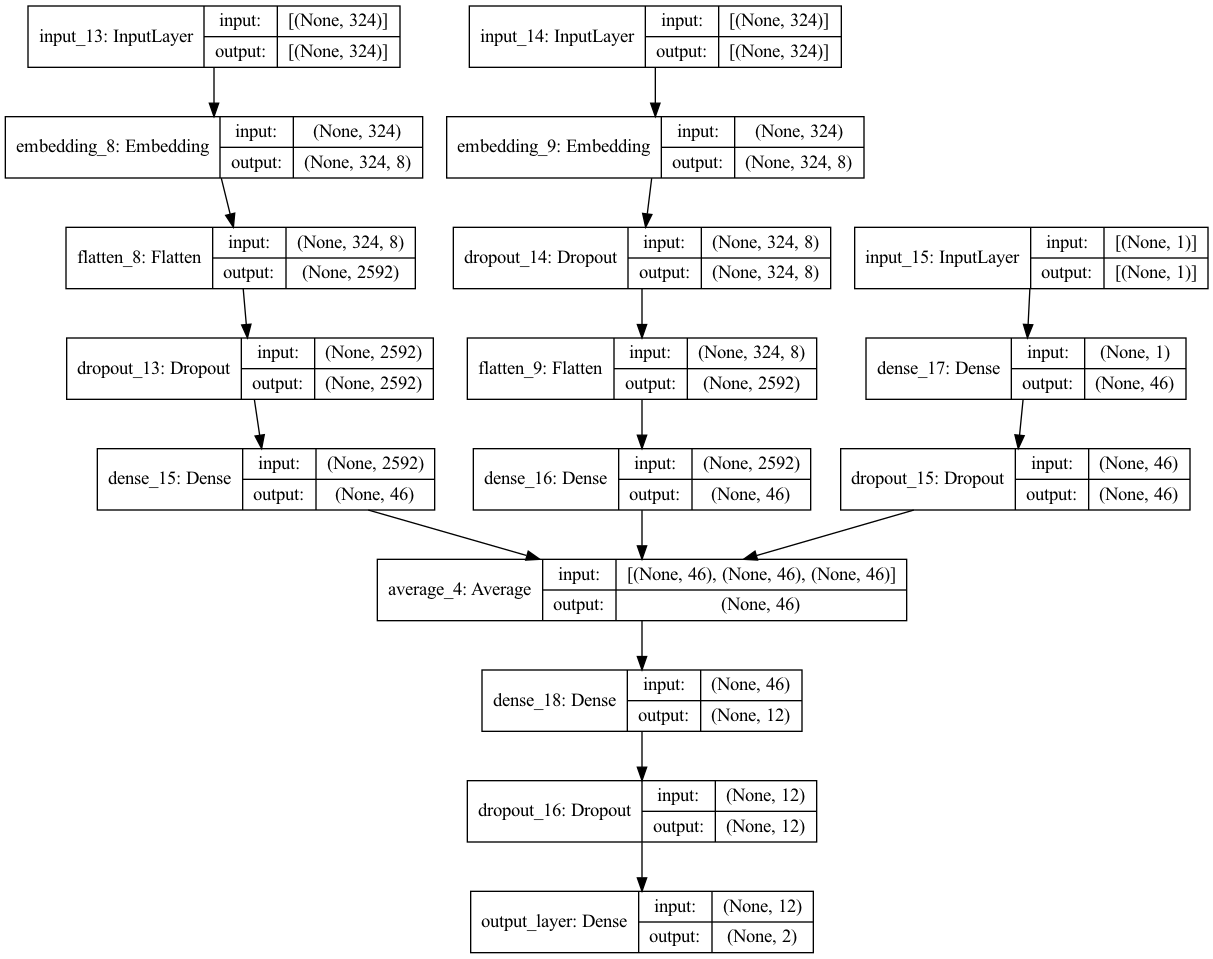

In [86]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='output/model_graph.png', show_shapes=True, show_layer_names=True)

In [87]:
history = model.fit([X_train_cm, X_train_tt, X_train_rt], y_train, verbose=1, epochs=25, validation_split=0.2, shuffle=True)
# 

Epoch 1/25
3150/3150 [==============================] - 14s 4ms/step - loss: 0.4389 - val_loss: 0.3704
Epoch 2/25
3150/3150 [==============================] - 13s 4ms/step - loss: 0.3683 - val_loss: 0.3413
Epoch 3/25
3150/3150 [==============================] - 13s 4ms/step - loss: 0.3506 - val_loss: 0.3292
Epoch 4/25
3150/3150 [==============================] - 13s 4ms/step - loss: 0.3432 - val_loss: 0.3253
Epoch 5/25
3150/3150 [==============================] - 14s 4ms/step - loss: 0.3393 - val_loss: 0.3234
Epoch 6/25
3150/3150 [==============================] - 13s 4ms/step - loss: 0.3367 - val_loss: 0.3225
Epoch 7/25
3150/3150 [==============================] - 14s 4ms/step - loss: 0.3350 - val_loss: 0.3221
Epoch 8/25
3150/3150 [==============================] - 14s 4ms/step - loss: 0.3328 - val_loss: 0.3191
Epoch 9/25
3150/3150 [==============================] - 14s 4ms/step - loss: 0.3300 - val_loss: 0.3183
Epoch 10/25
3150/3150 [==============================] - 14s 5ms/step - l

In [88]:
y_predict = model.predict([X_test_cm, X_test_tt, X_test_rt])
y_predict = np.argmax(y_predict, axis=1)
y_test = np.argmax(y_test, axis=1)

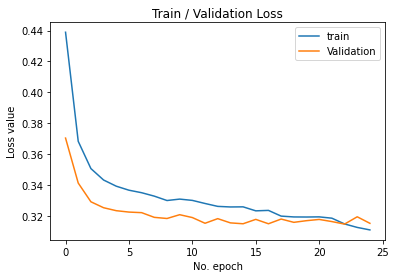

In [89]:
import matplotlib.pyplot as plt


# Plot history: Accuracy
plt.title('Train / Validation Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend()
plt.savefig("output/tran-val-loss.png")
plt.show()

In [90]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
acc = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
print("accuracy: ", acc)
print("f1: ", f1)
print("recall: ", recall)
print("precision: ", precision)

accuracy:  0.8826666666666667
f1:  0.5374507227332458
recall:  0.4118371000223764
precision:  0.7733193277310925


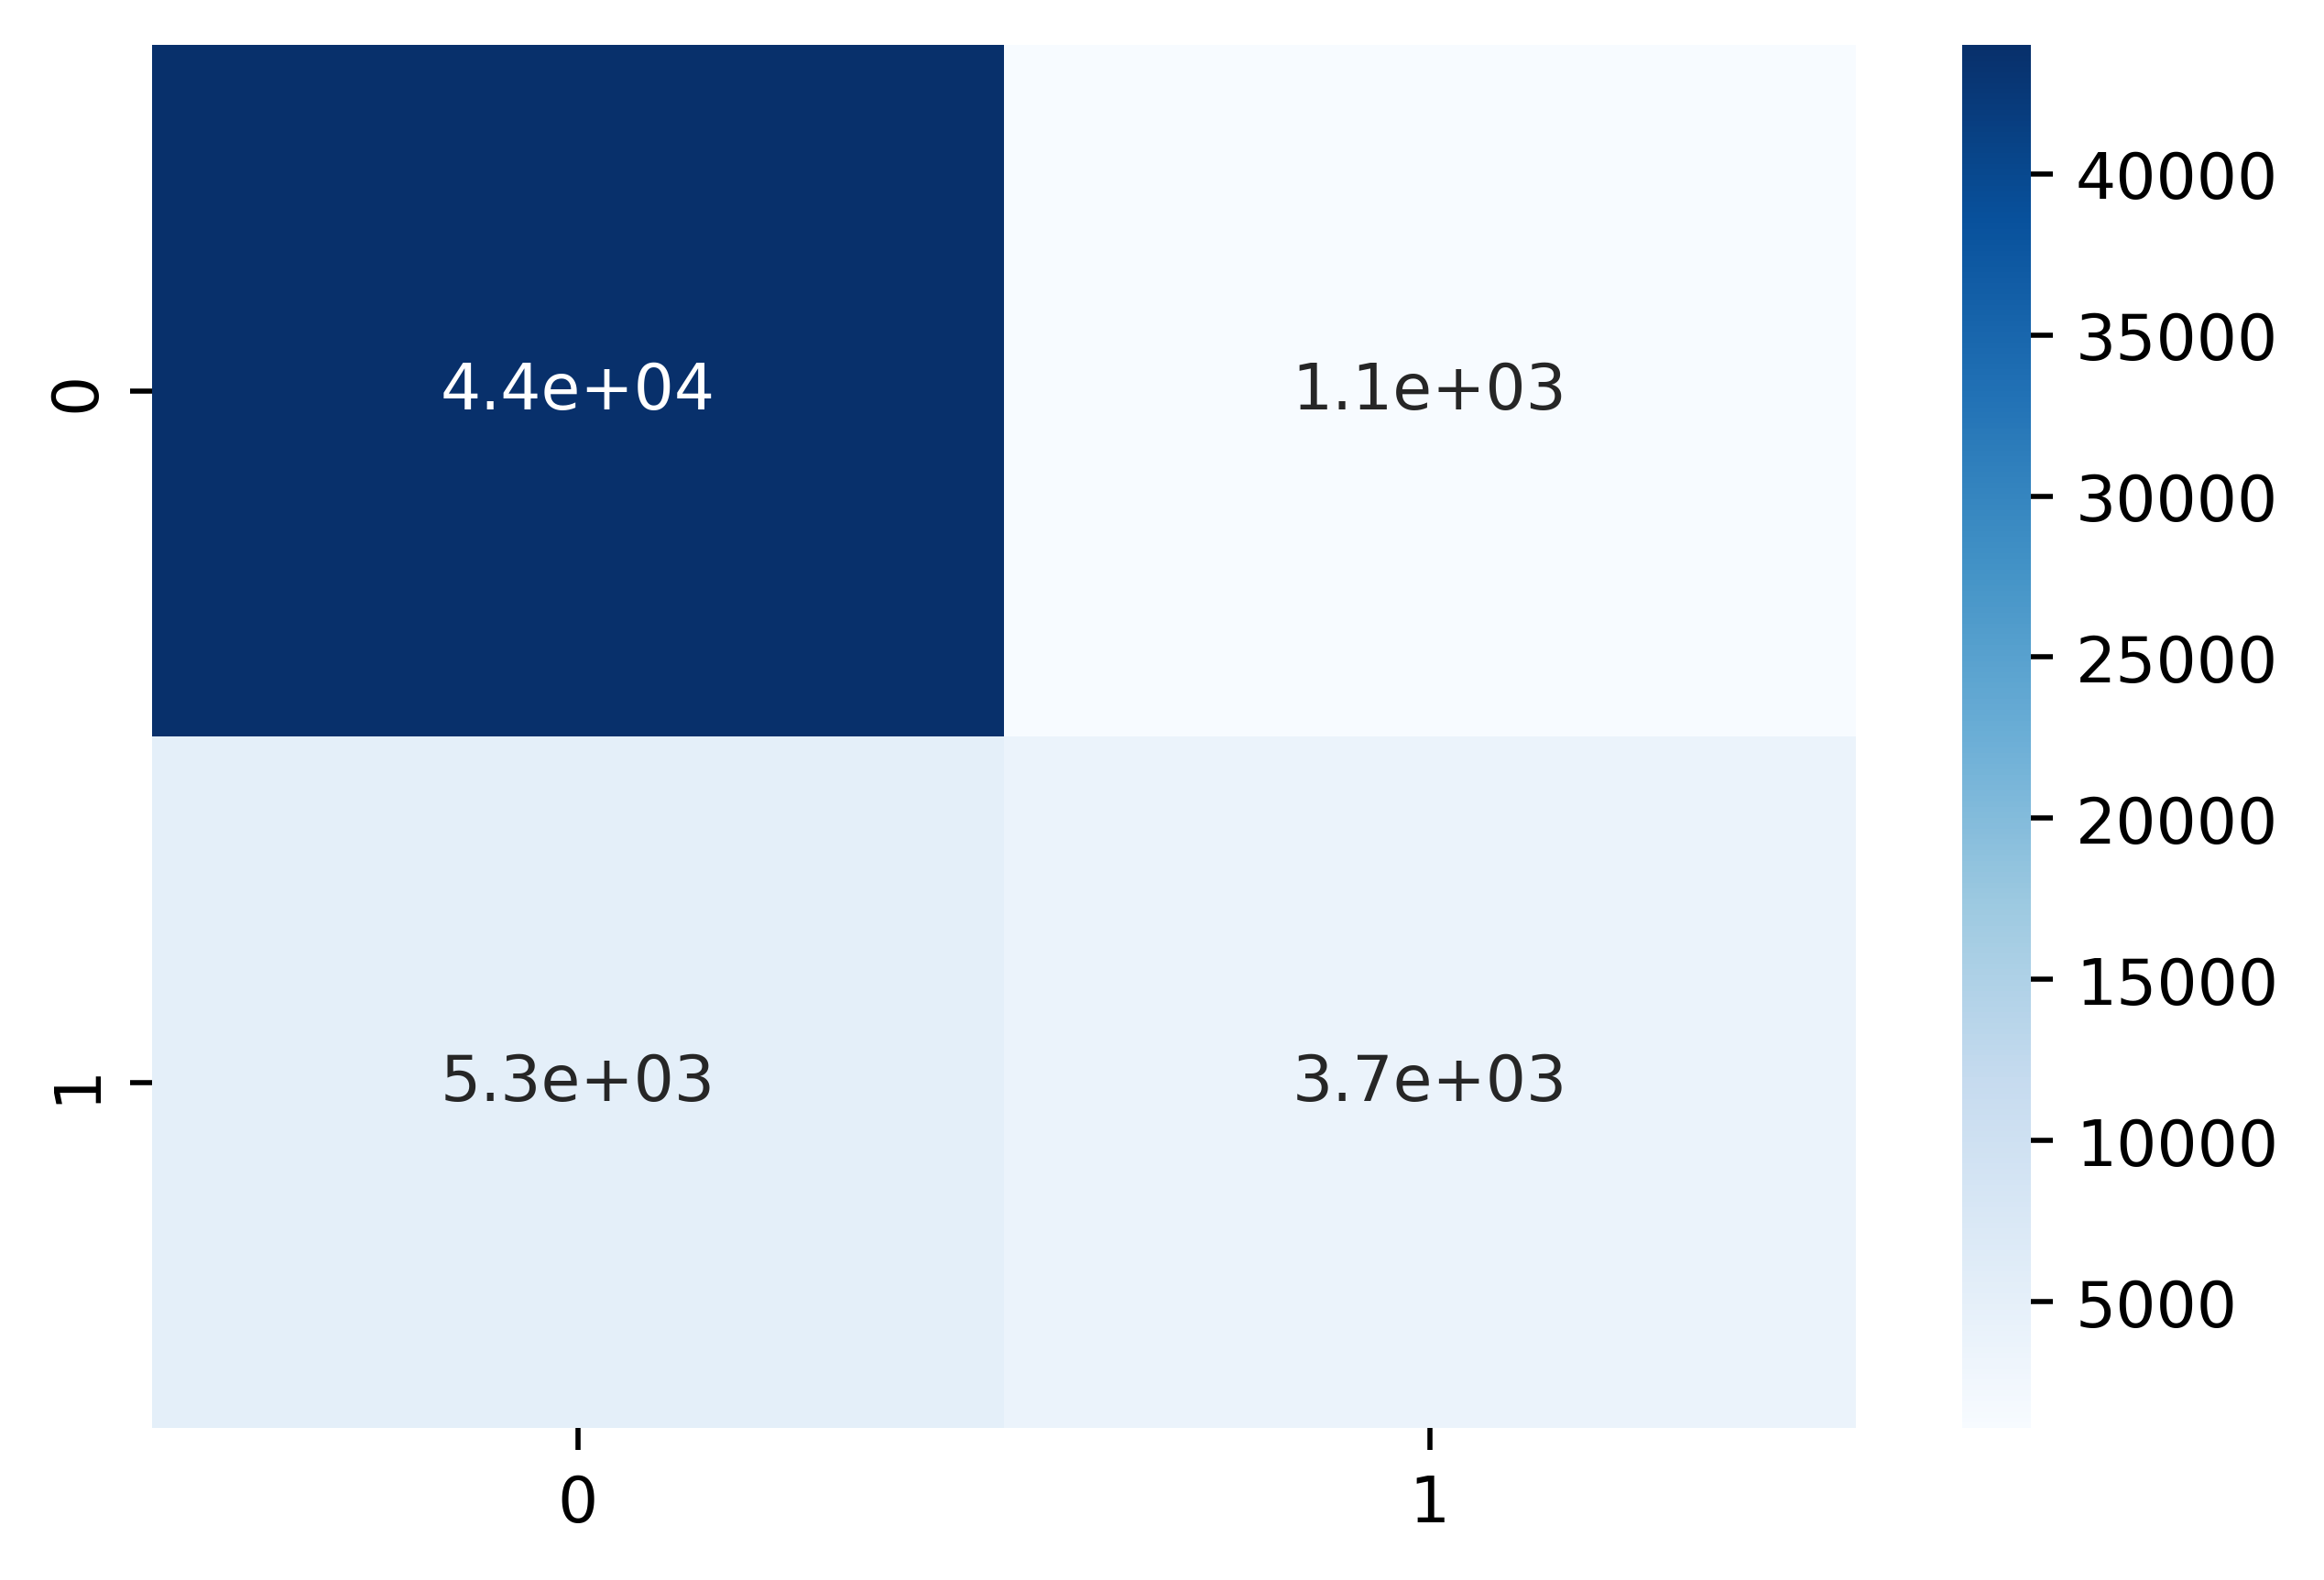

In [91]:
from sklearn.metrics import confusion_matrix
mx = confusion_matrix(y_test, y_predict)
import seaborn as sns
plt.figure( dpi=500)
sns.heatmap(mx, annot=True, cmap="Blues")
plot_path = os.path.join("output/confusion_matrix.png")
plt.savefig(plot_path)